## Vision Tutorial

I'm not caught up on fastai2 so let's run through some of the tutorials to get a sense for what's changed.

Based on: http://dev.fast.ai/tutorial.transfer_learning

In [1]:
import numpy as np

from functools import partial

from fastai2.optimizer import Adam
from fastai2.metrics import error_rate
from fastai2.callback.schedule import fit_one_cycle

from fastai2.vision.core import imagenet_stats, PILMask
from fastai2.vision.data import ImageBlock
from fastai2.vision.augment import RandomResizedCrop
from fastai2.vision.augment import aug_transforms
from fastai2.vision.learner import cnn_learner, cnn_config, unet_learner, unet_config

from fastai2.data.block import DataBlock, CategoryBlock
from fastai2.data.transforms import get_image_files, RandomSplitter, RegexLabeller, Normalize
from fastai2.data.external import URLs, untar_data

from torchvision.models import resnet34

In [2]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

In [3]:
image_path = untar_data(URLs.PETS)
image_path

Path('/home/josh/.fastai/data/oxford-iiit-pet')

In [4]:
dbunch = pets.databunch(image_path/'images', item_tfms=RandomResizedCrop(460, min_scale=0.75), 
                        bs=32,
                        batch_tfms=[*aug_transforms(size=299, max_warp=0), Normalize.from_stats(*imagenet_stats)])

In [5]:
len(dbunch.train_ds.items)

5912

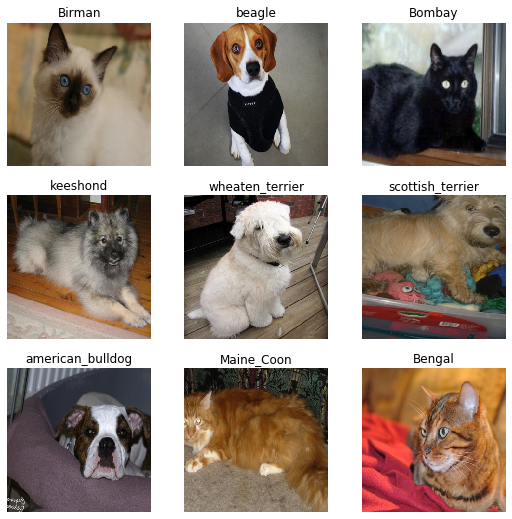

In [6]:
dbunch.show_batch(max_n=9)

In [7]:
opt_func = partial(Adam, lr=slice(3e-3), wd=0.01, eps=1e-8)
learn = cnn_learner(dbunch, resnet34, opt_func=opt_func, metrics=error_rate, config=cnn_config(ps=0.33))

In [8]:
learn.fit_one_cycle(1)

(#5) [0,0.591600239276886,0.26952531933784485,0.09336940944194794,'00:35']


In [9]:
learn.unfreeze()
# learn.fit_one_cycle(4, slice(1e-5, 1e-3))
learn.fit_one_cycle(1, slice(1e-5, 1e-3))

(#5) [0,0.40461811423301697,0.25279656052589417,0.08525033295154572,'00:48']


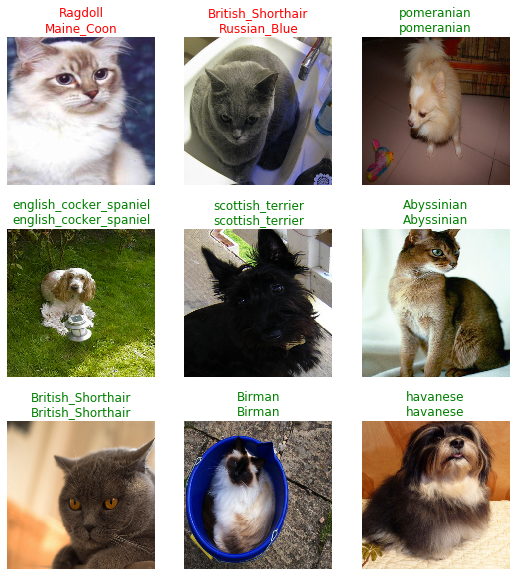

In [10]:
learn.show_results(max_n=9)

## Segmentation

In [11]:
path = untar_data(URLs.CAMVID_TINY)

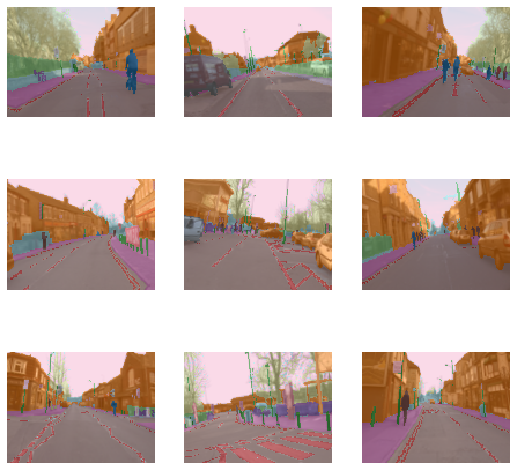

In [12]:
camvid = DataBlock(blocks=(ImageBlock, ImageBlock(cls=PILMask)),
                   get_items=get_image_files,
                   splitter=RandomSplitter(),
                   get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}')

dbunch = camvid.databunch(path/"images", batch_tfms=aug_transforms())
dbunch.show_batch(max_n=9, vmin=1, vmax=30)

In [13]:
dbunch.vocab = np.loadtxt(untar_data(URLs.CAMVID_TINY)/'codes.txt', dtype=str)

In [14]:
dbunch.vocab

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [15]:
learn = unet_learner(dbunch, resnet34, config=unet_config())
learn.fit_one_cycle(10, 1e-3)

(#4) [0,3.816756010055542,3.6593165397644043,'00:07']
(#4) [1,3.7699437141418457,3.7080817222595215,'00:01']
(#4) [2,3.6218745708465576,4.48685359954834,'00:01']
(#4) [3,3.4519965648651123,5.4652018547058105,'00:01']
(#4) [4,3.3055331707000732,7.9411301612854,'00:01']
(#4) [5,3.1780872344970703,10.144762992858887,'00:01']
(#4) [6,3.0713651180267334,8.065954208374023,'00:01']
(#4) [7,2.979848623275757,6.16801643371582,'00:01']
(#4) [8,2.9061107635498047,4.530613899230957,'00:01']
(#4) [9,2.8432223796844482,3.4403014183044434,'00:01']


In [16]:
learn.predict(dbunch.train_ds.items[0]);

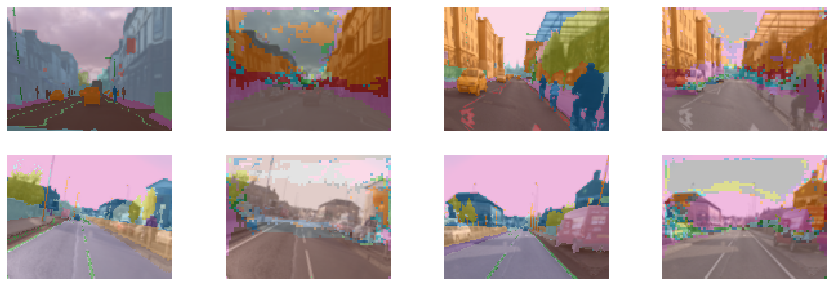

In [17]:
learn.show_results(max_n=4, figsize=(15,5))